# NHL Visiting Teams Analysis 

### By: John Palmer

Hi there. This is my first notebook on Kaggle that I'm using to practice ML techniques. I've grown up watching and playing hockey and figured this NHL data set would be a nice starting point. In this notebook, I create a model using XGBClassifier to predict whether the visiting hockey team will win their game. Still new to this, and definitely welcome to feedback. 

As always, need to import the necessary tools first.   

In [1]:
import matplotlib
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np
import seaborn as sns
import sklearn as sk 
import random as rd
import re 
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, plot_roc_curve, accuracy_score, roc_auc_score
from sklearn.impute import KNNImputer

%matplotlib inline

First, I will read in both datasets I will be using for the analysis. Specifically, the `team_data` dataset contains outcomes for both home and away teams. I figured that since these results are paired, 
this might cause an inflation of model performance if left in this format. Therefore, I will remove all the home team fields from the dataset, and add back some of their fields as additional columns (matching them to their corresponding row entry).

In [2]:
game_data = pd.read_csv("../input/nhl-game-data/game.csv", index_col=0)
team_data = pd.read_csv("../input/nhl-game-data/game_teams_stats.csv", index_col=0)
team_metadata = pd.read_csv("../input/nhl-game-data/team_info.csv", index_col=0)

# drop unnecessary columns
team_data = team_data.drop(['head_coach','goals', "team_id", "powerPlayGoals","startRinkSide"], axis=1)
team_data.sort_index(axis=0, inplace=True)

# Separate the home and away teams to prevent use of overlapping data
hmask = team_data.HoA == "home"
home_data = team_data[hmask]
away_data = team_data[~hmask]

# Edit home and away datasets
home_data = home_data.drop(["won", "settled_in", "faceOffWinPercentage"], axis=1)
home_data = home_data.add_prefix("home_")
away_data = away_data.add_prefix("away_")

# Add specific home features to the away dataset
team_data = pd.concat([away_data, home_data], axis=1)

Next, I will address missing, duplicated, or problematic entries. 

In [3]:
# Remove missing entries with missing hits (easiest choice because of strong overlap with other NAs; i.e. giveaways, takeaways, blocked)
team_data = team_data[~team_data.away_hits.isnull()]

# KNN Imputation to address missing "faceOffWinPercentage" values
imputer = KNNImputer()
team_data.away_faceOffWinPercentage = imputer.fit_transform(np.array(team_data.away_faceOffWinPercentage).reshape(-1,1))


# Remove uninformative values in "settled_in"
team_data = team_data[~(team_data.away_settled_in == "tbc")]

# I found that there are a collection of games in the early 2000s where it seems that these 6 measures were not being recorded
# Therefore, I opt to remove any entries where all six of these features are 0 
toRemove = ((team_data.away_giveaways== 0) & (team_data.away_takeaways == 0) 
          & (team_data.away_blocked == 0) & (team_data.home_giveaways == 0) 
          & (team_data.home_takeaways == 0) & (team_data.home_blocked == 0))
team_data = team_data[~toRemove]

# Remove duplicated entries 
print("Duplicated entries: {}\n".format(sum(team_data.index.duplicated())))
team_data = team_data[~team_data.index.duplicated()]

# Columns used to split data, no longer needed 
team_data = team_data.drop(['away_HoA', "home_HoA"], axis=1)

print(team_data.head())
print(team_data.shape)

Duplicated entries: 2565

            away_won away_settled_in  away_shots  away_hits  away_pim  \
game_id                                                                 
2002020801     False              OT        27.0       21.0      15.0   
2002020804     False             REG        20.0       10.0      10.0   
2002020811     False             REG        27.0        2.0      10.0   
2002020817     False             REG        17.0       29.0      14.0   
2002020821     False             REG        21.0        4.0       8.0   

            away_powerPlayOpportunities  away_faceOffWinPercentage  \
game_id                                                              
2002020801                          5.0                  48.412205   
2002020804                          2.0                  48.412205   
2002020811                          7.0                  48.412205   
2002020817                          4.0                  48.412205   
2002020821                          2.0   

I noticed that there are both "Standard" timezones and "Daylight" timezones in the data, which I feel, adds unnecessary complexity to the data. 
To remove this, I will use a regular expression to search for all daylight savings timezones and remap them to their "Standard" times. 

Duplicated entries: 2570



Text(0.5, 0, 'Timezone Offset')

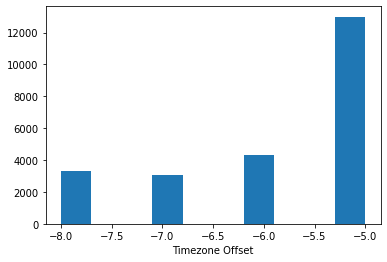

In [4]:
# Remove duplicated entries from the 2nd dataset
print("Duplicated entries: {}\n".format(sum(game_data.index.duplicated())))
game_data = game_data[~game_data.index.duplicated()]

# Readjust the timezones (exclude daylight savings)
def timezone_change(tz):
    res = re.search("[A-Z]DT", tz) 
    if res != None:
        return 1
    else:
        return 0 

# Find the offset of the daylight savings timezones
offset = game_data.venue_time_zone_tz.apply(timezone_change)

# Adjust the timezones 
game_data.venue_time_zone_offset = (game_data.venue_time_zone_offset - offset)

# Plot the finalized timezones 
plt.hist(game_data.venue_time_zone_offset)
plt.xlabel("Timezone Offset")

Here, I perform feature engineering to add two new variables to the data. One is the time of the game (specifically the hour on a 24hr clock), and the second is the difference in timezone between the visiting team and that of the venue. 

5


Text(0.5, 0, 'Away Timezone Difference')

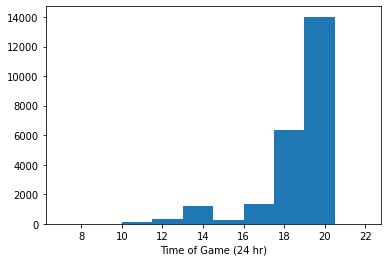

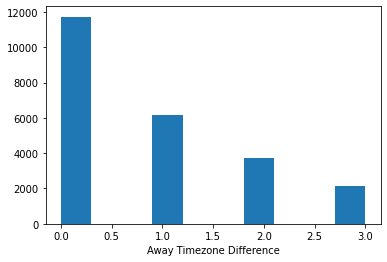

In [5]:
# NEW FEATURE : "game_time"
res = game_data.date_time_GMT.apply(lambda x: int(re.search("T(\d+):", x).group(1)))

game_data['game_time'] = (res + game_data.venue_time_zone_offset) % 24
plt.figure()
plt.hist(game_data['game_time'])  
plt.xlabel("Time of Game (24 hr)")

# Timezone mappings for all team IDs
timezones = {1:5, 4:5, 26:8, 14:5, 6:5, 3:5, 5:5, 17:5, 28:8, 18:6, 23:8, 16:6, 9:5, 
             8:5, 30:6, 15:5, 19:6, 24:8, 27:7, 2:5, 10:5,13:5, 7:5, 20:7, 21:7, 25:6, 29:5, 52:6, 22:7, 54:8, 12:5, 53:7, 11:5}

# These teams are not registered in the data set; remove them 
mask = game_data.away_team_id.isin([88, 87, 90])
print(sum(mask))
game_data = game_data.drop(game_data[mask].index)

# NEW FEATURE : "away_timezone" and "away_timechange" 
# "away_timechange" : the difference between the away team's timezone and that of the venue
game_data['away_timezone']  = -game_data.away_team_id.apply(lambda x: timezones[x])
game_data['away_timechange'] = np.abs(game_data.away_timezone - game_data.venue_time_zone_offset)

plt.figure()
plt.hist(game_data['away_timechange'])
plt.xlabel("Away Timezone Difference")

In [6]:
toAdd = game_data[['season','type','game_time','away_timezone','away_timechange','venue_time_zone_offset']]
toAdd2 = toAdd.loc[team_data.index,:]

data = pd.concat([team_data, toAdd2], axis=1)
print(f"Final Dataset Dimensions: {game_data.shape}\n")

Final Dataset Dimensions: (23730, 17)



Here, I am considering dropping the `season` feature from the data, but I will do a quick visualization to if there are any trends. 

Text(0, 0.5, 'Number of away-wins / Total Games')

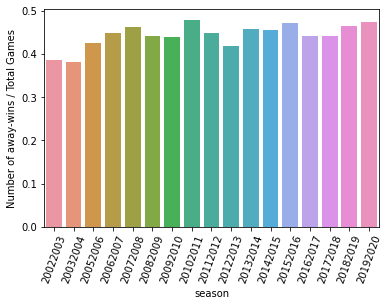

In [7]:
# calculate proportion of visiting team wins per season
res = data.groupby('season').sum()['away_won'] / data.groupby('season').size()

plot = sns.barplot(x=res.index, y=res, data=data)
plot = plot.set_xticklabels(labels=res.index,rotation=70)
plt.ylabel("Number of away-wins / Total Games")

Interestingly, there seems to be some differences in the proportion of games won by visiting teams between different hockey seasons. The lower values in the earlier seasons may prove helpful to the model, so I am going to leave this feature in. 

In [8]:
# Collect categorical variables 
categorical = [name for name in data.columns if data[name].dtype == 'object']
categorical = categorical + ["season", "away_timezone", "venue_time_zone_offset", "game_time"]

# Collect numeric variables 
numeric = [column for column in data.columns if column not in categorical]
numeric.remove("away_won")
print(categorical)
print(numeric)

# Set up core pipeline for preprocessing
categorical_transform = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown = "ignore"))])

num_transform = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocess = ColumnTransformer(
    transformers=[
        ('num', num_transform, numeric),
        ('cat', categorical_transform, categorical)])

['away_settled_in', 'type', 'season', 'away_timezone', 'venue_time_zone_offset', 'game_time']
['away_shots', 'away_hits', 'away_pim', 'away_powerPlayOpportunities', 'away_faceOffWinPercentage', 'away_giveaways', 'away_takeaways', 'away_blocked', 'home_shots', 'home_hits', 'home_pim', 'home_powerPlayOpportunities', 'home_giveaways', 'home_takeaways', 'home_blocked', 'away_timechange']


Here, I split the data into the appropriate train and test sets. 

In [9]:
label = LabelEncoder()
y = pd.Series(label.fit_transform(data.away_won))
X = data.iloc[:,1:]
y.index = X.index
#X_try = preprocess.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

def compute_performance(yhat, y, classes):
    # First, get tp, tn, fp, fn
    tp = sum(np.logical_and(yhat == classes[1], y == classes[1]))
    tn = sum(np.logical_and(yhat == classes[0], y == classes[0]))
    fp = sum(np.logical_and(yhat == classes[1], y == classes[0]))
    fn = sum(np.logical_and(yhat == classes[0], y == classes[1]))

    print(f"tp: {tp} tn: {tn} fp: {fp} fn: {fn}")
    
    # Accuracy
    acc = (tp + tn) / (tp + tn + fp + fn)
    
    # Precision
    # "Of the ones I labeled +, how many are actually +?"
    precision = tp / (tp + fp)
    
    # Recall
    # "Of all the + in the data, how many do I correctly label?"
    recall = tp / (tp + fn)    
    
    # Sensitivity
    # "Of all the + in the data, how many do I correctly label?"
    sensitivity = recall
    
    # Specificity
    # "Of all the - in the data, how many do I correctly label?"
    specificity = tn / (fp + tn)
    
    # Print results
    
    print("Accuracy:",round(acc,3),"Recall:",round(recall,3),"Precision:",round(precision,3),
          "Sensitivity:",round(sensitivity,3),"Specificity:",round(specificity,3))


# Logistic Regression

I'll start by modelling using a standard logistic regression model. Here, I create a pipeline and evaluate the model performance using cross-validation. I further examine the model performance by examining scores associated with the confusion matrix (using `compute_performance`).

In [10]:
log_model = Pipeline([
    ('preprocess',preprocess),
    ('log',LogisticRegression( max_iter=10000))
])

cv_score = cross_val_score(log_model, X_train, y_train, cv=8, scoring='roc_auc')

print(f"Mean CV AUROC Score: {cv_score.mean()}")

log_model.fit(X_train, y_train)


y_test_pred = log_model.predict(X_test)
y_test_prob = log_model.predict_proba(X_test)

compute_performance(y_test_pred, y_test, log_model.classes_)


Mean CV AUROC Score: 0.717701603684747
tp: 1018 tn: 1694 fp: 570 fn: 806
Accuracy: 0.663 Recall: 0.558 Precision: 0.641 Sensitivity: 0.558 Specificity: 0.748


### Polynomial with L1 Penalty

Just out of curiosity, I want to see whether there are potentially non-linear relationships between features and outcomes. Here, I will experiment by adding a 2nd order polynomial transformation of the numeric features. I will also change the penalization of the model from `None` to the "LASSO" or L1 penalty. This is because I now have a lot of newly added features from the polynomial expansion and want to perform some implicit feature selection (setting coefficients to 0). 

In [11]:
poly_transform = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(2, include_bias=False)),
    ('scaler2', StandardScaler())])

poly_preprocess = ColumnTransformer(
    transformers=[
        ('num', poly_transform, numeric),
        ('cat', categorical_transform, categorical)])

poly_log_model = Pipeline([
    ('preprocess',poly_preprocess),
    ('log',LogisticRegression(solver='saga',penalty='l1', max_iter=10000, n_jobs=8))
])


cv_score = cross_val_score(poly_log_model, X_train, y_train, cv=8, scoring='roc_auc', n_jobs=8)
print(f"Mean CV AUROC Score: {cv_score.mean()}")

poly_log_model.fit(X_train, y_train)
log_model.fit(X_train, y_train)

# Evaluate model performance on the test data
y_test_pred = log_model.predict(X_test)
y_test_prob = log_model.predict_proba(X_test)

compute_performance(y_test_pred, y_test, log_model.classes_)


Mean CV AUROC Score: 0.7186483861219637
tp: 1018 tn: 1694 fp: 570 fn: 806
Accuracy: 0.663 Recall: 0.558 Precision: 0.641 Sensitivity: 0.558 Specificity: 0.748


There was a very small improvement in AUROC score, but no tangible improvement in model performance. Moving forward, I will continue with the base model without the polynomials transformation (though I will still be testing it off script). 


# Random Forest

I want to gain more experience using random forest models, so I'll choose to fit one here. I want to see whether this offers any notable improvement over the standard logistic regression. To create the model, I will use my original preprocessor without polynomial transformations and tune the number of trees parameter before fitting. 

50.0
75.0
100.0
125.0
150.0
175.0
200.0
225.0
250.0
275.0
300.0
325.0
350.0
375.0
400.0
425.0
450.0
475.0
500.0
525.0
550.0
[0.3789454367506728, 0.36817959383410814, 0.3636530462441889, 0.36047222901884024, 0.35453878150232443, 0.3525813555174945, 0.35074626865671643, 0.35184732077318326, 0.3544164423782725, 0.35245901639344257, 0.3502569121605089, 0.3487276731098605, 0.3498898947883533, 0.34866650354783457, 0.34707609493516023, 0.34517983851235623, 0.3449351602642525, 0.3452410080743822, 0.34530217763640814, 0.3452410080743822, 0.3445681428920969]


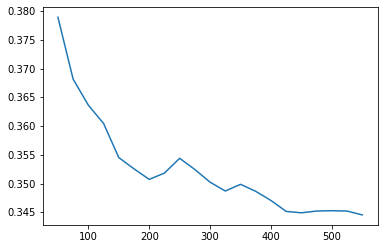

In [12]:
numTrees = np.linspace(50,550, num=21)

rf_model = Pipeline([
    ('preprocess',preprocess),
    ('rf', RandomForestClassifier(oob_score=True, 
                               random_state=0,
                               n_jobs=8))
])

error = []

for i in range(len(numTrees)):
  print(numTrees[i])
  rf_model.named_steps['rf'].set_params(n_estimators=int(numTrees[i]))
  rf_model.fit(X_train, y_train)
  oob_error = 1 - rf_model.named_steps['rf'].oob_score_
  error.append( oob_error)

print(error)
plt.plot(numTrees, error)
plt.ylabel("Out-of-bag Error")
plt.xlabel("Number of Trees")


Based on the tuning above, it appears that 450 trees would be an appropriate choice for `n_estimators` given that no significant decreases in the out-of-bag error can be detected beyond this point. However, I also want to try a more involved approach using `GridSearchCV`. Using grid search will allow me to tune the `max_depth` parameter in addition to the `n_estimators`. Below, I will use 8-fold cross-validation on a smaller dataset to tune these parameters. 

In [13]:
rf_model = Pipeline([
    ('preprocess',preprocess),
    ('rf', RandomForestClassifier(oob_score=True, 
                               random_state=0,
                               n_jobs=8))
])

params = dict({'rf__max_depth': [5, 10, 20, 30, 50],
         'rf__n_estimators':[100, 200, 500, 800, 1000 ]})

# Create a smaller sample size to tune parameters on 
X_tune = X_train.sample(frac=0.5)
y_tune = y_train[X_tune.index]

grid_rf = GridSearchCV(rf_model, 
                      param_grid=params, 
                      cv = 5,
                      scoring = 'roc_auc',
                      n_jobs=8,
                      refit = False,
                      verbose=1)
grid_rf.fit(X_tune, y_tune)

grid_rf.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


{'rf__max_depth': 20, 'rf__n_estimators': 1000}

I now have my tuned parameters for the `max_depth` and `n_estimators` to use in a finalized random forest classifier model. Here, I'll fit that model to the training data and evaluate my performance on the testing dataset. 

In [14]:
rf_final = Pipeline([
    ('preprocess',preprocess),
    ('rf', RandomForestClassifier(oob_score=True,
                                  n_estimators=800,
                                  max_depth=20,
                               random_state=0,
                               n_jobs=8))
])

rf_final.fit(X_train, y_train)

# Evaluate model performance on the test data
y_rf_pred = rf_final.predict(X_test)
y_rf_pred_prob = rf_final.predict_proba(X_test)

print(f"RF AUROC Score : {roc_auc_score(y_test, y_rf_pred_prob[:,1])}")

RF AUROC Score : 0.7283910347312628


# Gradient Boosting (XGBoost)

Next, I want to test whether a gradient boosted decision tree model might outperform this random forest classifier. To approach this, I will create a dictionary of parameter values that I want to tune. Here, I am including the `learning_rate` as a new tunable parameter, in addition to the original `max_depth` and `n_estimators` used previously in the random forest. 

In [15]:
xg_model = Pipeline([
    ('preprocess',preprocess),
    ('xg', XGBClassifier(n_jobs=8, objective='binary:logistic', random_state=0 ,gamma=0.1))
])


params = dict({'xg__learning_rate': [0.001, 0.01, 0.1,0.2],
         'xg__max_depth': [2, 3, 4],
         'xg__n_estimators':[100, 200,300, 400, 500 ]})
print(params)

# Create a smaller sample size to tune parameters on 
X_tune = X_train.sample(frac=0.5)
y_tune = y_train[X_tune.index]

grid_xg = GridSearchCV(xg_model, 
                      param_grid=params, 
                      cv = 5,
                      scoring = 'roc_auc',
                      n_jobs=8,
                      refit = False,
                      verbose=1)
grid_xg.fit(X_tune, y_tune)

grid_xg.best_params_

{'xg__learning_rate': [0.001, 0.01, 0.1, 0.2], 'xg__max_depth': [2, 3, 4], 'xg__n_estimators': [100, 200, 300, 400, 500]}
Fitting 5 folds for each of 60 candidates, totalling 300 fits


{'xg__learning_rate': 0.1, 'xg__max_depth': 3, 'xg__n_estimators': 200}

Using the tuned parameter values above, I will fit my finalized XGBoost classifier model to the training data and evaluate its performance on the testing dataset. 

In [16]:
xg_final = Pipeline([
    ('preprocess',preprocess),
    ('xg', XGBClassifier(learning_rate=0.1,objective='binary:logistic', max_depth=3, n_estimators = 500, n_jobs=8, random_state=0 ,gamma=0.1, verbosity=0))
])

xg_final.fit(X_train, y_train)

y_xg_pred = xg_final.predict(X_test)
y_xg_pred_prob = xg_final.predict_proba(X_test)

print(f"XG AUROC Score : {roc_auc_score(y_test, y_xg_pred_prob[:,1])}")

c:\users\john\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XG AUROC Score : 0.7212316347405616


This score was subject to some variability, but did not reach higher than 0.72. The random forest classifier appeared to perform better given its higher AUROC score, so I will focus on it for the remaining investigation. 

# Final Model

I have chosen to further investigate my finalized random forest model, since it has the highest AUROC score of 0.73.

### Feature Importance

First, I want to see which features are contributing to the model the most. With random forests, this is quite straightforward using the `feature_importances_` attribute. 

<AxesSubplot:title={'center':'Variable Importance - XGBoosted Model'}>

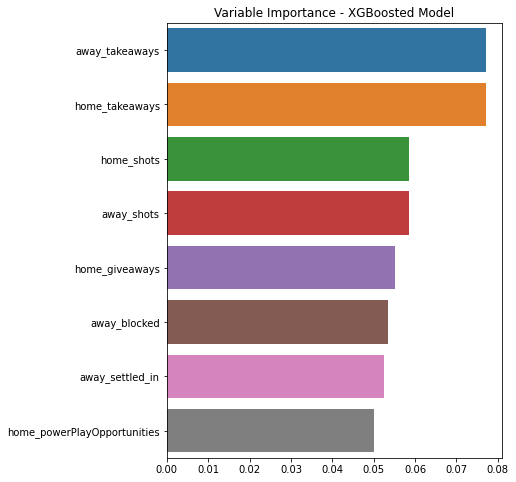

In [17]:
# Variable importance
importances = rf_final.named_steps['rf'].feature_importances_
indices = np.argsort(importances)[::-1]

# PLOTTING 
f,ax = plt.subplots(figsize=(6,8))
plt.title("Variable Importance - XGBoosted Model")
sns.barplot(y=[X_train.columns[i] for i in indices[0:8]] , x=importances[indices[0:8]])

Here, we can see the importance scores of the different features. Rather interesting to see that the number of takeaways by both the home and away team appear to contribute the most to predicting a win or loss. That could perhaps be a loose indication of how aggressively one team is chasing the other for the puck.

The number of shots by both teams is a rather expected result. It seems reasonable that a team that gets more shots on net in a game is more likely to win.  

Of the remaining features, `settled_in` was particularly interesting to see here. This indicates that a visiting team might be slightly more or less likely to win if the game proceeds into overtime. However, the importance of this feature is relatively low, so it is unreasonable to say anything conclusive here. 

### ROC Curve

AUROC: 0.7283910347312628


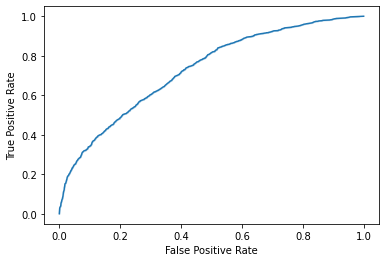

In [18]:
fpr, tpr, _ = roc_curve(y_test, y_rf_pred_prob[:,1])

ax=sns.lineplot(x=fpr,y=tpr)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")

print(f"AUROC: {auc(fpr, tpr)}")

The AUROC score for the best model is not fantastic, however, I am not surprised by this as hockey is known to have a reasonable level of "chance". Generally, models seems to have difficulty delivering reliable predictions of hockey outcomes. That being said, this model still provides a reasonable improvement over the baseline accuracy of 0.48 that might be achieved with random guessing. 

# Conclusions

- In this notebook, I implement XGBoost using Python and Scikit-Learn to predict whether a visiting hockey team will win a game 
- I trained two logistic regression models, one with the standard features and another with a polynomial transformation of them
- I trained a random forest model by tuning two parameters using standard iteration and using GridSearchCV
- I trained a gradient boosted decision tree model by tuning three parameters using GridSearchCV
- The random forest model performed best, yielding an AUC of about 0.73
- Given that hockey is a relatively hard sport to predict outcomes in, my model's performance seems adequate and acceptable